In [1]:
import glob 
import os
import sys
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from photutils.aperture import CircularAperture,CircularAnnulus,aperture_photometry
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sep, astroquery, astroscrappy, astropy
import matplotlib as mpl
from astroquery.jplhorizons import Horizons
import warnings
from astropy.utils.exceptions import AstropyWarning


print('Version----------')
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('astropy',astropy.__version__)
print('astroscrappy',astroscrappy.__version__)
print('astroquery',astroquery.__version__)



def circle_masking(image,x1,y1,r):

    Masking_image = np.zeros(np.shape(image))
    for yi in range(len(image)):
        for xi in range(len(image)):
                if (xi - x1)**2 + (yi-y1)**2 < (r)**2:
                    Masking_image[yi,xi] = 1
    return Masking_image

# def circle_masking_list(image,x1,y1,r):
#     Masking_image = np.zeros(np.shape(image))

#     for yi in range(len(image)):
#         for xi in range(len(image)):
#             for star in range(len(x1)):
#                 if (xi - x1[star])**2 + (yi-y1[star])**2 < (r)**2:
#                     Masking_image[yi,xi] = 1
#     return Masking_image

# def un_circle_masking(image,x1,y1,r):

#     for yi in range(len(image)):
#         for xi in range(len(image)):
#                 if (xi - x1)**2 + (yi-y1)**2 < (r)**2:
#                     image[yi,xi] = 0
#     return image


def skyvalue(data,y0,x0,r_in,r_out,masking):
    masking = masking.astype(bool)
    ann = CircularAnnulus([x0,y0],r_in=r_in, r_out = r_out)
    phot = aperture_photometry(data,ann,mask=masking)
    
    phot1 = aperture_photometry(masking*1,ann)
    pixel_count = phot1['aperture_sum'][0]    
    y_1 = int(y0-r_out)
    y_2 = int(y0+r_out)
    x_1 = int(x0-r_out)
    x_2 = int(x0+r_out)
    crop_image = data[y_1:y_2,x_1:x_2]
    crop_masking = masking[y_1:y_2,x_1:x_2]
    target_masking = circle_masking(crop_image,x0-x_1,y0-y_1,r_in)
    Masking_image = target_masking + crop_masking
    
    Sky_region = np.ma.masked_array(crop_image, Masking_image)
    sky_std = np.ma.std(Sky_region)
    sky = np.ma.median(Sky_region)
    npix = np.shape(Sky_region)[0]*np.shape(Sky_region)[1] - np.sum(Masking_image)

    
    return(sky,sky_std,ann.area)
    
def circle(x,y,r):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = r*np.cos(theta)+y
    x2 = r*np.sin(theta)+x
    return(x2.tolist(),x1.tolist())    
    
def signal_to_noise_oir_ccd(t, source_eps, sky_std, rd, npix):
    signal = t * source_eps 
    noise = np.sqrt(t * (source_eps  + npix *
                         (sky_std**2 )) + npix * rd ** 2)
    return signal / noise       

Version----------
pandas 1.4.4
numpy 1.21.5
astropy 5.1
astroscrappy 1.1.0
astroquery 0.4.7.dev8479


In [2]:

mpl.rc('figure', max_open_warning = 0)

np.set_printoptions(threshold=1000)
pd.set_option('display.max_rows', None)
warnings.simplefilter('ignore', category=AstropyWarning)

path = os.path.join('/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V')

filelist = glob.glob(os.path.join(path,'fb*AL*.fits'))
filelist = sorted(filelist)
target_name= '98943'
Observatory = 'Z23'
XY = None#(280,388)#None#if initial center of xy is fixed (no mag file is needed)
Image_category = None#'STD'

log = pd.DataFrame({})
for fi in filelist:
    hdul = fits.open(fi)
    header = hdul[0].header
    data = hdul[0].data
    log = pd.concat([log,
                     pd.DataFrame({'FILENAME':[os.path.split(fi)[-1]],
                                  'OBJECT':[header['OBJECT']],
                                  'IMAGETYP':[header['IMAGETYP']],
                                  'IMAGECAT':[header['IMAGECAT']],
                                  'FARETANG':[header['FARETANG']],
                                  'INSTRUME':[header['CHIPID']],
                                  'EXPTIME':[header['EXPTIME']],
                                  'SIZE':[np.shape(data)]})])
log        

,FILENAME,OBJECT,IMAGETYP,IMAGECAT,FARETANG,INSTRUME,EXPTIME,SIZE
0,fb_ALGb260257.98943.fits,98943 90deg,OBJECT,SCIENCE,90.0,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260258.98943.fits,98943 112.5deg,OBJECT,SCIENCE,112.5,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260259.98943.fits,98943 135deg,OBJECT,SCIENCE,135.0,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260260.98943.fits,98943 157.5deg,OBJECT,SCIENCE,157.5,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260261.98943.fits,98943 180deg,OBJECT,SCIENCE,180.0,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260262.98943.fits,98943 202.5deg,OBJECT,SCIENCE,202.5,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260263.98943.fits,98943 225deg,OBJECT,SCIENCE,225.0,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260264.98943.fits,98943 247.5deg,OBJECT,SCIENCE,247.5,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260265.98943.fits,98943 270deg,OBJECT,SCIENCE,270.0,12234-10-01,120.0,"(375, 375)"
0,fb_ALGb260266.98943.fits,98943 292.5deg,OBJECT,SCIENCE,292.5,12234-10-01,120.0,"(375, 375)"


/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260257.98943.fits
/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260257.98943.fits.mag.1


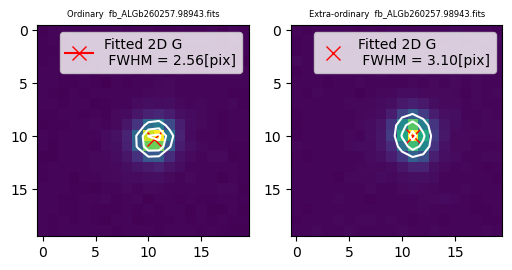

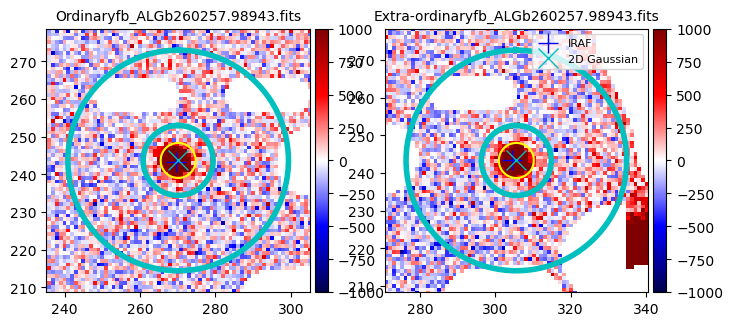

/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260258.98943.fits
/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260258.98943.fits.mag.1


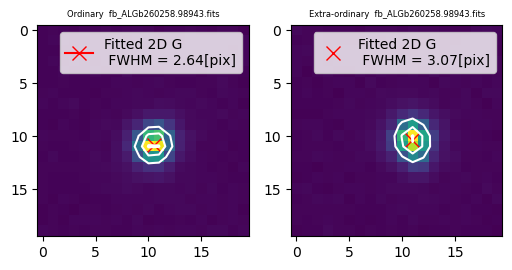

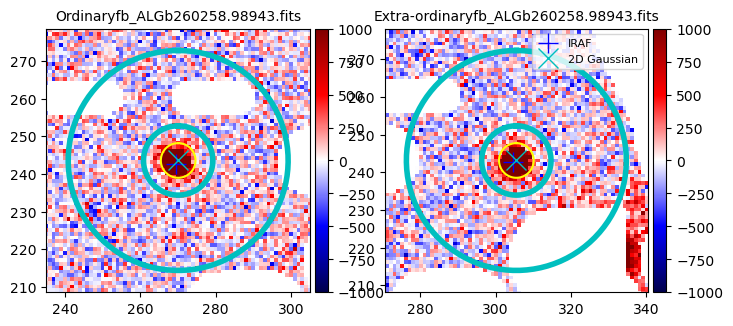

/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260259.98943.fits
/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260259.98943.fits.mag.1


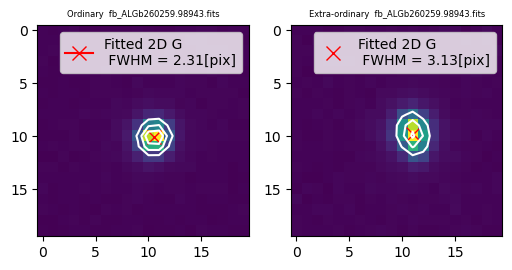

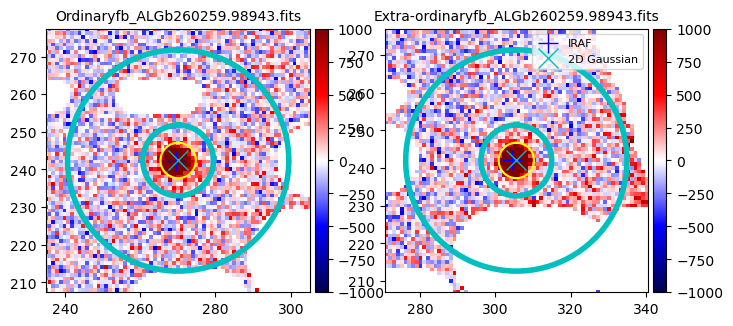

/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260260.98943.fits
/Users/judy/Library/CloudStorage/Dropbox/Research/2001CC21/data/polarimetry/FAPOL/230226/V/fb_ALGb260260.98943.fits.mag.1


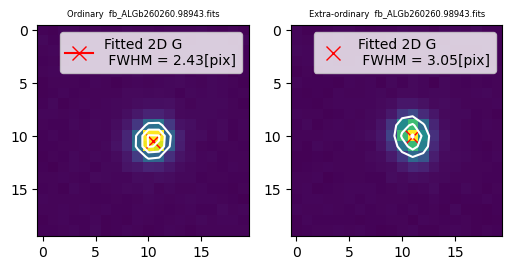

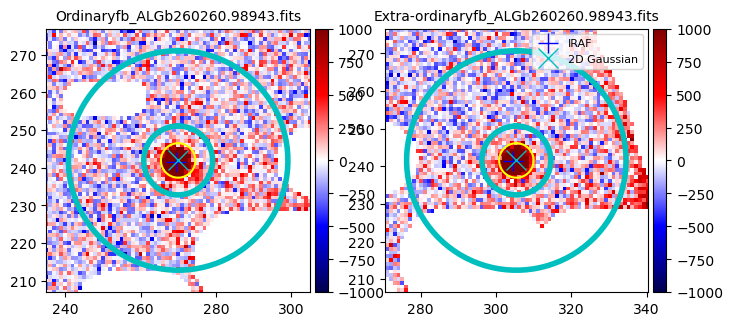

In [3]:
#======================================#
#             Photometry               #
#======================================#

figure_plot = 'yes'
saved_file_name = 'auto' 
ANN_scale = 6 #This value is decided by the visual inspection
Dan = 20
scale_masking = 6
aperture_scale = 3 #The aperture size would be the FWHM X aperture_scale [pix]


if not os.path.exists(os.path.join(path,'result')):
    os.makedirs(os.path.join(path,'result'))    

    
Photo_Log = pd.DataFrame({})
Example_file = filelist[:4] #Show only one set for the example
for nn, file in enumerate(Example_file):
    print(file)
    hdul = fits.open(file)[0]
    data = hdul.data
    header = hdul.header

    OBJECT = header['OBJECT']
    JD = Time(header['DATE-OBS'],format='isot').jd
    epoch = header['DATE-OBS']
    exptime = header['EXPTIME'] #in sec    
    EXPTIME = header['EXPTIME'] / (24*60*60)  #in jd
    EXP_str = Time(header['DATE-OBS'],format='isot').jd
    EXP_end = EXP_str + EXPTIME
    BIN = 1
    if np.shape(data) == (375,375):
        BIN = 2
    try:
        header['GAIN']
    except KeyError:
        gain = 0.16
        RN = 4.3
    else:
        gain = header['GAIN']
        RN = header['RDNOISE']

    RET1 = os.path.join(path,file.split('/')[-1])
    #Bring the x,y information of object from .mag.1
    if XY != None:
        xo,yo = XY[0],XY[1]
    else: 
        mag = ascii.read(RET1+'.mag.1')
        print(RET1+'.mag.1')
        xo = mag['XCENTER'][0] - 1
        yo = mag['YCENTER'][0] - 1

    xe = xo+70/BIN
    ye = yo

    #Bring Masking image
    mask_name = os.path.join(path,'mask_'+os.path.split(file)[-1])
    hdul_mask = fits.open(mask_name)[0]
    masking = hdul_mask.data  
    masking = (masking).astype(bool)
    masking_o = np.copy(masking)
    masking_e = np.copy(masking)
    Masked_image = np.ma.masked_array(data, masking)

    #Find the center & FWHM==========================================================
    #Determine FWHM
    ## Ordinary
    cutting = int(20/BIN)
    y_1, y_2 = int(yo-cutting), int(yo+cutting)
    x_1, x_2 = int(xo-cutting), int(xo+cutting)
    crop_o = data[y_1:y_2,x_1:x_2]
    crop_o = crop_o - np.median(crop_o[:,:int(10/BIN)])
    y, x = np.mgrid[:len(crop_o), :len(crop_o[0])]
    g_init = Gaussian2D(x_mean = cutting,y_mean=cutting,
                        theta=0,
                        amplitude=crop_o[cutting,cutting],
                        bounds={'x_mean':(18/BIN,22/BIN),
                                'y_mean':(18/BIN,22/BIN)})

    fitter = LevMarLSQFitter()
    fitted = fitter(g_init, x,y, crop_o)
    center_x = fitted.x_mean.value
    center_y = fitted.y_mean.value
    fwhm_o = max(fitted.x_fwhm,fitted.y_fwhm)

    ## Extra-Ordinary
    y_1, y_2 = int(ye-cutting), int(ye+cutting)
    x_1, x_2 = int(xe-cutting), int(xe+cutting)
    crop_e = data[y_1:y_2,x_1:x_2]
    crop_e = crop_e - np.median(crop_e[:,:int(10/BIN)])
    y, x = np.mgrid[:len(crop_e), :len(crop_e[0])]
    g_init = Gaussian2D(x_mean = cutting,y_mean=cutting,
                        theta=0,
                        amplitude=crop_e[cutting,cutting],
                        bounds={'x_mean':(18/BIN,22/BIN),
                                'y_mean':(18/BIN,22/BIN)})

    fitter = LevMarLSQFitter()
    fitted = fitter(g_init, x,y, crop_e)
    center_x = fitted.x_mean.value
    center_y = fitted.y_mean.value
    fwhm_e = max(fitted.x_fwhm,fitted.y_fwhm)    

    #masking the ordinary or extraordinary component
    mask_fwhm = max(fwhm_o,fwhm_e)
    for yi in range(len(masking)):
        for xi in range(len(masking[0])):
            if (xi - xo)**2 + (yi-yo)**2 < (scale_masking*mask_fwhm/2)**2 :
                masking_e[yi,xi] = 1    
            if (xi - xe)**2 + (yi-ye)**2 < (scale_masking*mask_fwhm/2)**2 :   
                masking_o[yi,xi] = 1    


     #### Re-Determine FWHM
    ######### Ordinary part
    y_1, y_2 = int(yo-cutting), int(yo+cutting)
    x_1, x_2 = int(xo-cutting), int(xo+cutting)


    crop_data = data[y_1:y_2,x_1:x_2]
    sky_tem,std_tem,sky_area_tem = skyvalue(data,yo,xo,25/BIN,35/BIN,masking_o)
    crop_data_sub = crop_data-sky_tem
    masking2 = masking_o[y_1:y_2,x_1:x_2]
    data2 = np.ma.masked_array(crop_data_sub,masking2)
    y, x = np.mgrid[:len(crop_data), :len(crop_data[0])]
    g_init = Gaussian2D(x_mean = cutting,y_mean=cutting,
                        x_stddev = 10/BIN*gaussian_fwhm_to_sigma,
                        y_stddev = 10/BIN*gaussian_fwhm_to_sigma,
                        amplitude=crop_o[cutting,cutting],
                        theta=0,
                        bounds={'x_mean':(15/BIN,25/BIN),
                                'y_mean':(15/BIN,25/BIN),
                                'x_stddev':(0.8,15),
                                'y_stddev':(0.8,15)})

    fitter = LevMarLSQFitter()
    fitted = fitter(g_init, x,y, data2)
    center_x = fitted.x_mean.value
    center_y = fitted.y_mean.value
    std_aper = max([fitted.x_stddev.value,fitted.y_stddev.value])

    re_g_init = Gaussian2D(amplitude=fitted.amplitude.value, 
                           x_mean = center_x,
                           y_mean = center_y,
                           x_stddev = fitted.x_stddev.value,
                           y_stddev = fitted.y_stddev.value)
    fitter = LevMarLSQFitter()
    fitted = fitter(re_g_init, x,y,data2)
    FWHM_AP_ordi = max([re_g_init.x_fwhm,re_g_init.y_fwhm])
    if nn!= 0:
        if FWHM_AP_ordi> 2* np.mean(Photo_Log['FWHM_ordi [pix]']):
            FWHM_AP_extra = Photo_Log['FWHM_ordi [pix]'].values[-1]
            print('Check FWHM ', file) 
    amp_o = re_g_init.amplitude.value

    xo_new = fitted.x_mean.value + (xo-cutting)
    yo_new = fitted.y_mean.value + (yo-cutting)


    if figure_plot == 'yes':

        fig,ax1 = plt.subplots(1,2,figsize=(6,3))
        ax1[0].imshow(data2)
        ax1[0].plot(fitted.x_mean.value,fitted.y_mean.value,marker='x',color='r',ms=10,
                    label='Fitted 2D G\n FWHM = {0:.2f}[pix]'.format(FWHM_AP_ordi))
        ax1[0].contour(x, y, fitted(x,y), 3, colors='w')
        ax1[0].set_title('Ordinary  '+ file.split('/')[-1],fontsize=6)
        ax1[0].legend()  

    ######### Extra-ordinary part
    y_1, y_2 = int(ye-cutting), int(ye+cutting)
    x_1, x_2 = int(xe-cutting), int(xe+cutting)

    crop_data = data[y_1:y_2,x_1:x_2]
    sky_tem,std_tem,sky_area_tem = skyvalue(data,ye,xe,20/BIN,30/BIN,masking_e)
    crop_data_sub = crop_data-sky_tem
    masking2 = masking_e[y_1:y_2,x_1:x_2]
    data2 = np.ma.masked_array(crop_data_sub,masking2)
    y, x = np.mgrid[:len(crop_data), :len(crop_data[0])]
    g_init = Gaussian2D(x_mean = cutting,y_mean=cutting,
                        x_stddev = 10/BIN*gaussian_fwhm_to_sigma,
                        y_stddev = 10/BIN*gaussian_fwhm_to_sigma,
                        amplitude=crop_e[cutting,cutting],
                        theta=0,
                        bounds={'x_mean':(15/BIN,25/BIN),
                                'y_mean':(15/BIN,25/BIN),
                                'x_stddev':(0.8,15),
                                'y_stddev':(0.8,15)})

    fitter = LevMarLSQFitter()
    fitted = fitter(g_init, x,y, data2)
    center_x = fitted.x_mean.value
    center_y = fitted.y_mean.value
    std_aper = max([fitted.x_stddev.value,fitted.y_stddev.value])

    re_g_init = Gaussian2D(amplitude=fitted.amplitude.value, 
                           x_mean = center_x,
                           y_mean = center_y,
                           x_stddev = fitted.x_stddev.value,
                           y_stddev = fitted.y_stddev.value)
    fitter = LevMarLSQFitter()
    fitted = fitter(re_g_init, x,y,data2)
    FWHM_AP_extra = max([re_g_init.x_fwhm,re_g_init.y_fwhm])
    if nn!= 0:
        if FWHM_AP_extra> 2* np.mean(Photo_Log['FWHM_extra [pix]']):
            FWHM_AP_extra = Photo_Log['FWHM_extra [pix]'].values[-1]
            print('Check FWHM ', file) 

    amp_e = re_g_init.amplitude.value

    xe_new = fitted.x_mean.value + (xe-cutting)
    ye_new = fitted.y_mean.value + (ye-cutting)

    if figure_plot == 'yes':
        ax1[1].imshow(data2)
        ax1[1].plot(fitted.x_mean.value,fitted.y_mean.value,marker='x',color='r',ms=10,
                    ls='',label='Fitted 2D G\n FWHM = {0:.2f}[pix]'.format(FWHM_AP_extra))
        ax1[1].contour(x, y, fitted(x,y), 3, colors='w')
        ax1[1].set_title('Extra-ordinary  '+ file.split('/')[-1],fontsize=6)
        ax1[1].legend()  
    plt.show()    


    #Select the larger FWHM 
    FWHM_sel = max(FWHM_AP_ordi,FWHM_AP_extra)
    hdul_mask = fits.open(mask_name)[0]
    masking = hdul_mask.data  
    cosmic_ray_mask = masking==1

    # Interpolate bad pixel
    data = data.byteswap().newbyteorder()      
    bkg_ = sep.Background(data, mask=masking.astype(bool), bw=5/BIN, bh=5/BIN, fw=5/BIN, fh=5/BIN)
    bkg_image_ = bkg_.back()      
    old_data_ = np.copy(data)
    data[cosmic_ray_mask] = bkg_image_[cosmic_ray_mask]



    hdul_mask = fits.open(mask_name)[0]
    masking = hdul_mask.data  
    star_mask = masking>1
   #Making the new masking image with new center
    masking_o = np.zeros(np.shape(masking))
    masking_e = np.zeros(np.shape(masking))
    #masking the ordinary or extraordinary component
    for yi in range(len(star_mask)):
        for xi in range(len(star_mask[0])):
            if (xi - xo_new)**2 + (yi-yo_new)**2 < (scale_masking*FWHM_sel/2)**2 :
                masking_e[yi,xi] = 1    
            if (xi - xe_new)**2 + (yi-ye_new)**2 < (scale_masking*FWHM_sel/2)**2 :   
                masking_o[yi,xi] = 1  


    #Masking image (maksing: target + stars)
    masking_e = masking_e+star_mask
    masking_o = masking_o+star_mask


    #### Set aperture size

    Aperture_radius = aperture_scale*FWHM_sel/2
    Ann = ANN_scale*FWHM_sel/2
    Ann_out = Ann+Dan
        

    ##Determine sky value by aperture   
    Aper_o = CircularAperture([xo_new,yo_new],Aperture_radius) #Set aperture
    sky_o,sky_std_o,area_o = skyvalue(data,yo_new,xo_new,Ann,Ann_out,masking_o) # Set area determinung Sk #[count]

    Aper_e = CircularAperture([xe_new,ye_new],Aperture_radius) #Set aperture
    sky_e,sky_std_e,area_e = skyvalue(data,ye_new,xe_new,Ann,Ann_out,masking_e) # Set area determinung Sk



    Flux_o = aperture_photometry(data - sky_o,Aper_o,masking_o)['aperture_sum'][0]
    ERR_o = np.sqrt(Flux_o + 3.14*Aperture_radius**2*(sky_std_o**2 +(RN)**2))
    Snr_o = signal_to_noise_oir_ccd(1,Flux_o,sky_std_o,RN,Aperture_radius**2*3.14)

    Flux_e = aperture_photometry(data - sky_e, Aper_e,masking_e)['aperture_sum'][0]
    Sum_e = aperture_photometry(data,Aper_e)['aperture_sum'][0]
    ERR_e = np.sqrt(Flux_e + 3.14*Aperture_radius**2*(sky_std_e**2 + (RN)**2))
    Snr_e = signal_to_noise_oir_ccd(1,Flux_e,sky_std_e,RN,Aperture_radius**2*3.14)

    #ADU -> [e]
    Flux_e_, ERR_e_, sky_e_, sky_std_e_ = gain*Flux_e, ERR_e*gain, gain*sky_e, gain*sky_std_e
    Flux_o_, ERR_o_, sky_o_, sky_std_o_ = gain*Flux_o, ERR_o*gain, gain*sky_o, gain*sky_std_o


    if figure_plot == 'yes':
        figsize = 70/BIN
        fig,ax = plt.subplots(1,2,figsize=(8,4))
        plot_data = np.ma.masked_array(data,masking_o)
        vmin,vmax = -1000,1000
        im = ax[0].imshow(plot_data - sky_o,vmin=vmin,vmax=vmax,cmap='seismic')
        xi,yi = circle(xo_new,yo_new,Aperture_radius)
        ax[0].plot(xi,yi,color='yellow',lw=1.5)
        xi,yi = circle(xo_new,yo_new,Ann)
        ax[0].plot(xi,yi ,color='c',lw=4)
        xi,yi = circle(xo_new,yo_new,Ann_out)
        ax[0].plot(xi,yi ,color='c',lw=4)
        ax[0].plot(xo,yo,marker='+',ls='',ms=15,color='b')
        ax[0].plot(xo_new,yo_new,marker='x',ms=15,ls='',color='c')
        ax[0].set_xlim(xo_new-figsize,xo_new+figsize)
        ax[0].set_ylim(yo_new-figsize,yo_new+figsize)
        ax[0].set_title('Ordinary'+file.split('/')[-1],fontsize=10)
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im,cax=cax) 

        plot_data = np.ma.masked_array(data,masking_e)
        im = ax[1].imshow(plot_data - sky_e,vmin=vmin,vmax=vmax,cmap='seismic')
        xi,yi = circle(xe_new,ye_new,Aperture_radius)
        ax[1].plot(xi,yi,color='yellow',lw=1.5)
        xi,yi = circle(xe_new,ye_new,Ann)
        ax[1].plot(xi,yi ,color='c',lw=4)
        xi,yi = circle(xe_new,ye_new,Ann_out)
        ax[1].plot(xi,yi ,color='c',lw=4)
        ax[1].plot(xe,ye,marker='+',ls='',ms=15,color='b',label='IRAF')
        ax[1].plot(xe_new,ye_new,marker='x',ms=15,ls='',color='c',label='2D Gaussian')
        ax[1].set_xlim(xe_new-figsize,xe_new+figsize)
        ax[1].set_ylim(ye_new-figsize,ye_new+figsize)
        ax[1].set_title('Extra-ordinary'+file.split('/')[-1],fontsize=10)
        ax[1].legend(fontsize=8)
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im,cax=cax) 
        plt.show()


    #if target = ast, bring the ephemeris info. from JPL
        #Bring the observer quantities from JPL Horizons==========================
    target_type = header['IMAGECAT']
    if target_type == 'SCIENCE' and Image_category == None:
        obj = Horizons(id=target_name,location=Observatory, epochs=JD)
        eph = obj.ephemerides()
        psANG = eph['sunTargetPA'][0] #[deg]
        pA = eph['alpha'][0] #[deg]  
        delta = eph['delta'][0]
        r = eph['r'][0]
    else:
        psANG = -999
        pA = -999
        delta = -999
        r = -999
        target_type = 'STD'

    Photo_Log = pd.concat([Photo_Log,
                           pd.DataFrame({
                                  'Object': [OBJECT],
                                  'filename':[file.split('/')[-1]],
                                  'HWPANGLE':[header['FARETANG']],
                                  'Filter':[header['ALFLTNM']],
                                  'DATE':[epoch.split('T')[0]],
                                  'UT':[epoch.split('T')[-1][:-4]],
                                  'Object':[header['OBJECT'].split(' ')[0]],
                                  'JD':[JD],
                                  'FWHM_ordi [pix]':[FWHM_AP_ordi],
                                  'FWHM_extra [pix]':[FWHM_AP_extra],
                                  'Aper_radius [pix]':[Aperture_radius],
                                  'EXPTIME':[exptime],
                                  'Ann':[Ann],
                                  'Ann_out':[Ann_out],
                                  'Dan':[Dan],
                                  'Aper_scale':[aperture_scale],
                                  'Flux_ordi [e]':[Flux_o_],
                                  'eFlux_ordi [e]':[ERR_o_],
                                  'Flux_extra [e]':[Flux_e_],
                                  'eFlux_extra [e]':[ERR_e_],
                                  'SNR_o':[Snr_o],
                                  'SNR_e':[Snr_e],
                                  'SNR':[np.mean([Snr_o,Snr_e])],
                                  'Sky_ordi [e]':[sky_o_],
                                 'std_Sky_extra [e]':[sky_std_o_],
                                  'Sky_extra [e]':[sky_e_],
                                  'std_Sky_ordi [e]':[sky_std_e_],
                                  'AIRMASS':[header['AIRMASS']],
                                 'Type':[target_type],
                                 'alpha [deg]':[pA],
                                  'PsANG [deg]':[psANG],
                                  'delta':[delta],
                                  'r':[r],
                                  'GAIN':[gain]})])

Phot_name = ['filename', 'Object', 'Type','DATE','UT','JD', 'Filter','HWPANGLE','EXPTIME','alpha [deg]',
             'Aper_radius [pix]', 'Aper_scale', 'FWHM_extra [pix]', 'FWHM_ordi [pix]',
             'Flux_extra [e]', 'eFlux_extra [e]', 'Flux_ordi [e]', 'eFlux_ordi [e]', 
             'PsANG [deg]',   'Sky_extra [e]', 'std_Sky_extra [e]','Sky_ordi [e]', 'std_Sky_ordi [e]','Ann',"Dan",'Ann_out',
             'SNR','SNR_o','SNR_e','AIRMASS','delta','r','GAIN']

Photo_Log = Photo_Log.reindex(columns = Phot_name)  
Photo_Log = Photo_Log.round({'FWHM_ordi [pix]': 3, 'FWHM_extra [pix]':3,
                             'Aper_radius [pix]':1,'Aper_scale':2,
                             'Flux_ordi [e]':3, 'eFlux_ordi [e]':3,
                             'Flux_extra [e]':3,'eFlux_extra [e]':3,
                             'Sky_ordi [e]':3, 'std_Sky_ordi [e]': 3,
                             'Sky_extra [e]':3, 'std_Sky_extra [e]': 3,
                             'Ann':2,'Dan':2,'Ann_out':2,'SNR':2,'AIRMASS':2,
                             'SNR_o':2,'SNR_e':2,'PsANG [deg]':2,'alpha [deg]':2,
                            'HWPANGLE':2,'EXPTIME':2,'CROT_STR':4,'NROT_STR':4,
                            'delta':2,'r':2})

#     Photo_Log.to_csv(os.path.join(path,'result',saved_file_name))

Log_file = pd.DataFrame({'Object': [OBJECT.split(' ')[0]],
                         'Date':[epoch.split('T')[0].replace('-','_')],
                        'aperture_scale':[aperture_scale],
                        'ANN_scale':[ANN_scale],
                        'Dan':[Dan],
                        'MASK_scale':[scale_masking]})
#     Log_file.to_csv(os.path.join(ssubpath,'Log_{0}_{1}_ap{2:.2f}_sep.csv'.format(epoch.split('T')[0].replace('-','_'),OBJECT.split(' ')[0],
#                                                                       aperture_scale)))

Print the aperture photometric result. These results are used for deriving the stokes parameters

In [4]:
pd.set_option('display.max_columns', None)
Photo_Log   

,filename,Object,Type,DATE,UT,JD,Filter,HWPANGLE,EXPTIME,alpha [deg],Aper_radius [pix],Aper_scale,FWHM_extra [pix],FWHM_ordi [pix],Flux_extra [e],eFlux_extra [e],Flux_ordi [e],eFlux_ordi [e],PsANG [deg],Sky_extra [e],std_Sky_extra [e],Sky_ordi [e],std_Sky_ordi [e],Ann,Dan,Ann_out,SNR,SNR_o,SNR_e,AIRMASS,delta,r,GAIN
0,fb_ALGb260257.98943.fits,98943,SCIENCE,2023-02-26,20:39:42,2.460002e+06,V_Bes 530_80,90.0,120.0,68.01,4.6,3,3.097,2.562,75252.872,307.873,67648.843,289.799,100.12,1130.193,32.853,1123.266,34.940,9.29,20,29.29,238.93,233.43,244.43,1.21,0.13,1.03,0.16
0,fb_ALGb260258.98943.fits,98943,SCIENCE,2023-02-26,20:41:50,2.460002e+06,V_Bes 530_80,112.5,120.0,68.01,4.6,3,3.067,2.639,72273.421,297.753,67203.050,291.231,100.12,1127.258,33.374,1122.110,34.050,9.20,20,29.20,236.74,230.75,242.73,1.21,0.13,1.03,0.16
0,fb_ALGb260259.98943.fits,98943,SCIENCE,2023-02-26,20:43:57,2.460002e+06,V_Bes 530_80,135.0,120.0,68.01,4.7,3,3.127,2.314,67694.409,300.786,70220.002,295.896,100.11,1129.316,33.228,1123.792,33.943,9.38,20,29.38,231.19,237.31,225.06,1.21,0.13,1.03,0.16
0,fb_ALGb260260.98943.fits,98943,SCIENCE,2023-02-26,20:46:05,2.460002e+06,V_Bes 530_80,157.5,120.0,68.02,4.6,3,3.047,2.434,67167.382,306.684,66942.324,293.686,100.11,1133.460,33.930,1125.066,35.633,9.14,20,29.14,223.47,227.94,219.01,1.21,0.13,1.03,0.16
